In [1]:
import random
import networkx as nx

This is the part of calculating APT

In [2]:
def compute_flow_edges(A_size, I_size, neighbors):
    """
    Build flow network and return edges (a, i) with unit flow (Ef).
    """
    Gf = nx.DiGraph()
    source = "s"
    sink = "t"

    # Add nodes
    Gf.add_node(source)
    Gf.add_node(sink)

    for a in range(A_size):
        Gf.add_node(("a", a))
        Gf.add_edge(source, ("a", a), capacity=2)

    for i in range(I_size):
        Gf.add_node(("i", i))
        Gf.add_edge(("i", i), sink, capacity=2)

    # Add edges between advertisers and types
    for i in range(I_size):
        for a in neighbors[i]:
            Gf.add_edge(("a", a), ("i", i), capacity=1)

    flow_value, flow_dict = nx.maximum_flow(Gf, source, sink)

    Ef = []
    for a in range(A_size):
        a_node = ("a", a)
        if a_node not in flow_dict:
            continue
        for i in range(I_size):
            i_node = ("i", i)
            if i_node in flow_dict[a_node] and flow_dict[a_node][i_node] == 1:
                Ef.append((a, i))

    return Ef


In [3]:
def build_subgraph_and_components(A_size, I_size, Ef):
    """
    Build undirected subgraph H from Ef and return connected components as edge lists.
    Nodes are 0..A_size-1 for advertisers, A_size..A_size+I_size-1 for types.
    """
    # adjacency list for H
    H_adj = {u: set() for u in range(A_size + I_size)}
    edges_set = set()

    for (a, i) in Ef:
        u = a
        v = A_size + i
        H_adj[u].add(v)
        H_adj[v].add(u)
        edges_set.add((min(u, v), max(u, v)))

    visited = set()
    components = []  # list of list-of-edges (in this component)

    for start in range(A_size + I_size):
        if start in visited or len(H_adj[start]) == 0:
            continue

        # BFS/DFS to get all nodes in component
        stack = [start]
        comp_nodes = set()
        while stack:
            u = stack.pop()
            if u in visited:
                continue
            visited.add(u)
            comp_nodes.add(u)
            for v in H_adj[u]:
                if v not in visited:
                    stack.append(v)

        # collect edges in this component
        comp_edges = []
        for (u, v) in edges_set:
            if u in comp_nodes and v in comp_nodes:
                comp_edges.append((u, v))
        components.append((comp_nodes, comp_edges))

    return H_adj, components


In [4]:
def order_edges_in_component(comp_nodes, comp_edges, H_adj):
    """
    Given one connected component (path or cycle), return the edges in walk order.
    Nodes are integers in the H graph.
    """
    # build local adjacency
    adj = {u: set() for u in comp_nodes}
    for (u, v) in comp_edges:
        adj[u].add(v)
        adj[v].add(u)

    # count degrees
    degree = {u: len(adj[u]) for u in comp_nodes}

    # detect path vs cycle
    endpoints = [u for u in comp_nodes if degree[u] == 1]
    if len(endpoints) == 0:
        # cycle: start from any node
        start = next(iter(comp_nodes))
    else:
        # path: start from one endpoint
        start = endpoints[0]

    ordered_edges = []
    visited_edges = set()
    current = start
    prev = None

    # walk until we visited all edges in this component
    total_edges = len(comp_edges)
    while len(ordered_edges) < total_edges:
        for nxt in adj[current]:
            e = (min(current, nxt), max(current, nxt))
            if e in visited_edges:
                continue
            visited_edges.add(e)
            ordered_edges.append((current, nxt))
            prev, current = current, nxt
            break

    return ordered_edges, (len(endpoints) == 0), endpoints  # edges, is_cycle, endpoints


In [5]:
def color_component(comp_nodes, comp_edges, H_adj, A_size):
    """
    Color one component's edges blue/red according to TSM rules.
    Return dict: key = (a, i), value = "blue"/"red".
    """
    if not comp_edges:
        return {}

    ordered_edges, is_cycle, endpoints = order_edges_in_component(
        comp_nodes, comp_edges, H_adj
    )
    m = len(ordered_edges)

    # Each edge is between u (maybe advertiser) and v (maybe type)
    # We store colors by edge index in ordered_edges first.
    colors = [""] * m

    # helper: classify node as 'A' or 'I'
    def node_type(u):
        return "A" if u < A_size else "I"

    # Determine type of component
    if is_cycle:
        # cycle: alternate blue, red, ...
        for idx in range(m):
            colors[idx] = "blue" if idx % 2 == 0 else "red"
    else:
        # path
        start = endpoints[0]
        end = endpoints[1]
        start_type = node_type(start)
        end_type = node_type(end)

        if m % 2 == 1:
            # odd-length path: alternate blue/red so that blue = red + 1
            # simple: start with blue
            for idx in range(m):
                colors[idx] = "blue" if idx % 2 == 0 else "red"
        else:
            # even-length path
            if start_type == "A" and end_type == "A":
                # A-A path: alternate blue/red
                for idx in range(m):
                    colors[idx] = "blue" if idx % 2 == 0 else "red"
            elif start_type == "I" and end_type == "I":
                # I-I path: first two edges blue, then alternate red/blue...
                if m >= 1:
                    colors[0] = "blue"
                if m >= 2:
                    colors[1] = "blue"
                for idx in range(2, m):
                    # pattern: edge 2 = red, 3 = blue, 4 = red, ...
                    colors[idx] = "red" if (idx % 2 == 0) else "blue"
            else:
                # mixed A-I path; not supposed to happen in TSM structure, but fall back to simple alternation
                for idx in range(m):
                    colors[idx] = "blue" if idx % 2 == 0 else "red"

    # Now convert back to (a, i) indices and assign color
    edge_color_ai = {}
    for idx, (u, v) in enumerate(ordered_edges):
        col = colors[idx]
        # map u, v to (a, i)
        if u < A_size:
            a = u
            i = v - A_size
        else:
            a = v
            i = u - A_size
        edge_color_ai[(a, i)] = col

    return edge_color_ai


In [6]:
def compute_blue_red_matchings(A_size, I_size, neighbors):
    """
    From type graph, compute blue_for_type[i], red_for_type[i].
    """
    Ef = compute_flow_edges(A_size, I_size, neighbors)
    H_adj, components = build_subgraph_and_components(A_size, I_size, Ef)

    blue_for_type = [None] * I_size
    red_for_type = [None] * I_size

    for comp_nodes, comp_edges in components:
        edge_color_ai = color_component(comp_nodes, comp_edges, H_adj, A_size)
        for (a, i), col in edge_color_ai.items():
            if col == "blue":
                blue_for_type[i] = a
            elif col == "red":
                red_for_type[i] = a

    return blue_for_type, red_for_type

In [7]:
def simulate_tsm_once(A_size, I_size, neighbors, p, T, blue_for_type, red_for_type):
    """
    Simulate one run of TSM for horizon T.
    Returns:
    ALG: matched advertisers count
    hat_I: list of impression ids
    edges_real: list of (a, imp_id) edges in realization graph
    imp_type: list mapping imp_id -> type i
    """
    x = [0] * I_size  # type counters
    matched_A = [False] * A_size
    ALG = 0

    hat_I = []
    imp_type = []
    edges_real = []

    for _ in range(T):
        # sample a type according to p
        i = random.choices(range(I_size), weights=p, k=1)[0]

        imp_id = len(hat_I)
        hat_I.append(imp_id)
        imp_type.append(i)

        # build realization edges for this impression
        for a in neighbors[i]:
            edges_real.append((a, imp_id))

        # TSM online matching
        if x[i] == 0:
            a = blue_for_type[i]
            if a is not None and not matched_A[a]:
                matched_A[a] = True
                ALG += 1
        elif x[i] == 1:
            a = red_for_type[i]
            if a is not None and not matched_A[a]:
                matched_A[a] = True
                ALG += 1
        # else x[i] >= 2: ignore

        x[i] += 1

    return ALG, hat_I, edges_real, imp_type

In [8]:
def compute_opt_from_realization(A_size, hat_I, edges_real):
    """
    Compute offline OPT as maximum bipartite matching on realization graph.
    """
    G = nx.Graph()
    left_nodes = []

    # add advertiser nodes
    for a in range(A_size):
        node = f"a_{a}"
        G.add_node(node, bipartite=0)
        left_nodes.append(node)

    # add impression nodes
    for imp_id in hat_I:
        node = f"i_{imp_id}"
        G.add_node(node, bipartite=1)

    # add edges
    for (a, imp_id) in edges_real:
        G.add_edge(f"a_{a}", f"i_{imp_id}")

    # maximum bipartite matching
    matching = nx.algorithms.bipartite.maximum_matching(G, top_nodes=left_nodes)

    # count how many advertisers are matched
    matched_count = 0
    for a in range(A_size):
        node = f"a_{a}"
        if node in matching:
            matched_count += 1

    return matched_count

In [9]:
# This is trying to calculate OPT with Gurobi. It should be equivalent to the above function.
import gurobipy as gp
from gurobipy import GRB

def compute_opt_from_realization_gurobi(A_size, hat_I, edges_real):
    model = gp.Model("max_matching")
    model.setParam("OutputFlag", 0)  

    x = {}
    for (a, imp_id) in edges_real:
        x[(a, imp_id)] = model.addVar(vtype=GRB.BINARY, name=f"x_{a}_{imp_id}")

    model.update()

    # Every Advertiser at most one match
    for a in range(A_size):
        vars_for_a = [x[(aa, imp)] for (aa, imp) in x.keys() if aa == a]
        if vars_for_a:
            model.addConstr(gp.quicksum(vars_for_a) <= 1, name=f"adv_cap_{a}")

    # Every Impression at most one match
    for imp_id in hat_I:
        vars_for_imp = [x[(a, ii)] for (a, ii) in x.keys() if ii == imp_id]
        if vars_for_imp:
            model.addConstr(gp.quicksum(vars_for_imp) <= 1, name=f"imp_cap_{imp_id}")

    # Objective: maximize the number of matched edges
    model.setObjective(gp.quicksum(x.values()), GRB.MAXIMIZE)

    model.optimize()

    if model.Status != GRB.OPTIMAL:
        # If there's an issue
        return 0

    OPT = int(round(model.ObjVal))
    return OPT

ModuleNotFoundError: No module named 'gurobipy'

In [ ]:
def simulate_many_runs(A_size, I_size, neighbors, p, T, num_runs=1):
    blue_for_type, red_for_type = compute_blue_red_matchings(
        A_size, I_size, neighbors
    )

    ratios = []
    for _ in range(num_runs):
        ALG, hat_I, edges_real, imp_type = simulate_tsm_once(
            A_size, I_size, neighbors, p, T, blue_for_type, red_for_type
        )
        OPT = compute_opt_from_realization(A_size, hat_I, edges_real)
        if OPT > 0:
            ratios.append(ALG / OPT)

    avg_ratio = sum(ratios) / len(ratios) if ratios else 0.0
    return avg_ratio, ratios


This is for a small example and test

In [ ]:
#if __name__ == "__main__":
# random.seed(0)

#for example a small graph to test

A_size = 12

I_size = 3

neighbors = [
    list(range(12)),
    list(range(12)),
    list(range(12)),  
]


p = [0.25, 0.25,0.5] 
T = 10

avg_ratio = simulate_many_runs(A_size, I_size, neighbors, p, T, num_runs=15)
print("Average ALG/OPT ratio over runs:", avg_ratio)

Average ALG/OPT ratio over runs: (0.47333333333333333, [0.5, 0.4, 0.5, 0.5, 0.5, 0.4, 0.5, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.5])


Generating random graphs and plots the ratio

Average ratio over all random graphs: 0.6806263100561862


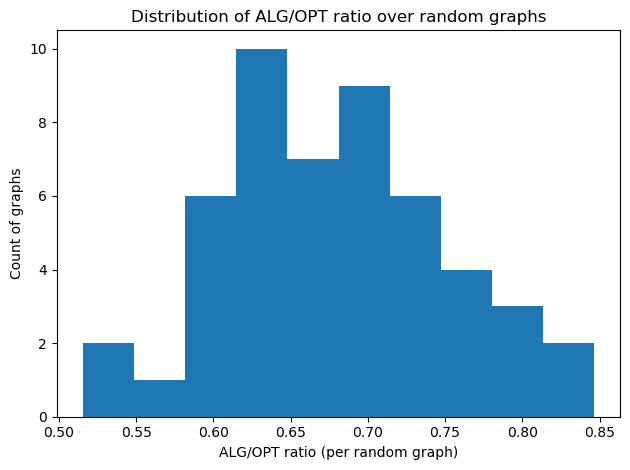

In [ ]:
import matplotlib.pyplot as plt
import random

def generate_random_graph(A_size, I_size, edge_prob):
    """
    neighbors[i] = list of advertisers a that impression type i can connect to.
    Each edge (a, i) is included independently with probability edge_prob.
    """
    neighbors = []
    for i in range(I_size):
        neigh_i = [a for a in range(A_size) if random.random() < edge_prob]
        if not neigh_i:  # avoid isolated types if you want
            neigh_i = [random.randrange(A_size)]
        neighbors.append(neigh_i)
    return neighbors

def random_probability_vector(I_size):
    """Random probability vector over impression types 0..I_size-1."""
    raw = [random.random() for _ in range(I_size)]
    s = sum(raw)
    return [x / s for x in raw]

def simulate_random_graphs(
    num_graphs,
    A_size,
    I_size,
    edge_prob,
    T,
    num_runs_per_graph=20,
):
    """
    For num_graphs random graphs, compute the average ALG/OPT ratio
    using simulate_many_runs().
    """
    avg_ratios = []
    for _ in range(num_graphs):
        neighbors = generate_random_graph(A_size, I_size, edge_prob)
        p = random_probability_vector(I_size)

        # simulate_many_runs returns (avg_ratio, ratios_list)
        avg_ratio, _ = simulate_many_runs(
            A_size, I_size, neighbors, p, T, num_runs=num_runs_per_graph
        )

        avg_ratios.append(avg_ratio)

    return avg_ratios

# ===== run experiment and plot =====

A_size = 20       # number of advertisers
I_size = 10       # number of impression types
edge_prob = 0.3   # edge probability in G(A, I, E)
T = 50            # number of arriving customers
num_graphs = 50   # how many random graphs to simulate
num_runs_per_graph = 30

ratios = simulate_random_graphs(
    num_graphs,
    A_size,
    I_size,
    edge_prob,
    T,
    num_runs_per_graph=num_runs_per_graph,
)

print("Average ratio over all random graphs:", sum(ratios) / len(ratios))

plt.figure()
plt.hist(ratios, bins=10)
plt.xlabel("ALG/OPT ratio (per random graph)")
plt.ylabel("Count of graphs")
plt.title("Distribution of ALG/OPT ratio over random graphs")
plt.tight_layout()
plt.show()# ===== run experiment and scatter plot =====

A_size = 20
I_size = 10
edge_prob = 0.3
T = 50
num_graphs = 50
num_runs_per_graph = 30

ratios = simulate_random_graphs(
    num_graphs,
    A_size,
    I_size,
    edge_prob,
    T,
    num_runs_per_graph=num_runs_per_graph,
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (51,) + inhomogeneous part.

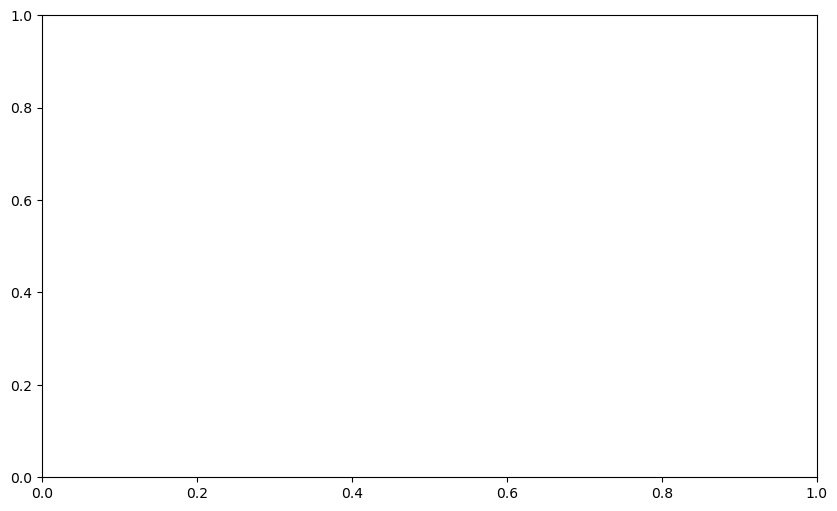

In [ ]:
import matplotlib.pyplot as plt

# 参数设置
A_size = 100
I_size = 100
edge_prob = 0.05
num_graphs_per_T = 50   # 每个 T 的随机图数量
num_runs_per_graph = 20 # 每张图内部重复模拟次数（用你 simulate_many_runs 的参数）

Ts = []
ratios = []

for T in range(0, 10,5):  # T 从 0 到 100
    if T == 0:
        # T = 0 时没有 arrival，ratio 没意义，这里直接设成 0 仅为了在图上有个点
        Ts.append(0)
        ratios.append(0.0)
        continue

    for _ in range(num_graphs_per_T):
        # 生成随机图和随机到达分布 p
        neighbors = generate_random_graph(A_size, I_size, edge_prob)
        p = random_probability_vector(I_size)

        # 对这张图做多次模拟，得到平均 ratio
        ratio = simulate_many_runs(
            A_size,
            I_size,
            neighbors,
            p,
            T,
            num_runs=num_runs_per_graph
        )

        Ts.append(T)
        ratios.append(ratio)

# 画散点图
plt.figure(figsize=(10, 6))
plt.scatter(Ts, ratios, s=10, alpha=0.4)
plt.xlabel("T (number of arrivals)")
plt.ylabel("ALG / OPT ratio")
plt.title("Scatter plot of ratio vs T (A=100, I=100, edge_prob=0.05)")
plt.grid(True)
plt.show()
